# ResNet18 + CIFAR100 の性能確認



In [1]:
# Set Project Root Directory
import os

current_dir = os.getcwd()
root_marker = "common"
while current_dir != os.path.dirname(current_dir):
    if root_marker in os.listdir(current_dir):
        break
    current_dir = os.path.dirname(current_dir)

project_root = current_dir
if os.getcwd() != project_root:
    %cd {project_root};

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from timm.optim import Lookahead
import lightning as L
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchinfo import summary

from common.optim.ranger import Ranger
from common.optim.sam import SAM, bypass_running_stats
from common.utils.training import evaluate
from common.loss.acls import ACLS

In [4]:
names = list()
results = dict()

## Architecture

In [66]:
summary(resnet18(weights=None, num_classes=100), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 100]                  --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]             --
│

## Train

### RA, MSLR

In [3]:
def train_cifar100_rn18_ra_mslr(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-3,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer=optimizer,
        milestones=[100, 150],
        gamma=0.1,
    )
    criterion = nn.CrossEntropyLoss()

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()

            total_loss += loss.item() * len(x)

        scheduler.step()
        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_RA_MSLR.pth')
    return dict(logs)

In [4]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_RA_MSLR'
results['CIFAR100_RN18_RA_MSLR'] = fabric.launch(train_cifar100_rn18_ra_mslr)
names.append(name)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Seed set to 51966


Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 1/200, LOSS: 4.08092
EPOCH: 10/200, LOSS: 2.72322
EPOCH: 20/200, LOSS: 2.29282
EPOCH: 30/200, LOSS: 2.05540
EPOCH: 40/200, LOSS: 1.89835
EPOCH: 50/200, LOSS: 1.77726
EPOCH: 60/200, LOSS: 1.67580
EPOCH: 70/200, LOSS: 1.59086
EPOCH: 80/200, LOSS: 1.52341
EPOCH: 90/200, LOSS: 1.44571
EPOCH: 100/200, LOSS: 1.38917
EPOCH: 110/200, LOSS: 1.14978
EPOCH: 120/200, LOSS: 1.11021
EPOCH: 130/200, LOSS: 1.09168
EPOCH: 140/200, LOSS: 1.06769
EPOCH: 150/200, LOSS: 1.05165
EPOCH: 160/200, LOSS: 1.03598
EPOCH: 170/200, LOSS: 1.02225
EPOCH: 180/200, LOSS: 1.02845
EPOCH: 190/200, LOSS: 1.01849
EPOCH: 200/200, LOSS: 1.01834


### RA, OCLR

In [24]:
def train_cifar100_rn18_ra_oclr(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss()

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_RA_OCLR.pth')
    return dict(logs)

In [25]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_RA_OCLR'
results['CIFAR100_RN18_RA_OCLR'] = fabric.launch(train_cifar100_rn18_ra_oclr)
names.append(name)

Using bfloat16 Automatic Mixed Precision (AMP)
Seed set to 51966


Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 1/200, LOSS: 4.41419
EPOCH: 10/200, LOSS: 3.11357
EPOCH: 20/200, LOSS: 2.74740
EPOCH: 30/200, LOSS: 2.47731
EPOCH: 40/200, LOSS: 2.26125
EPOCH: 50/200, LOSS: 2.08712
EPOCH: 60/200, LOSS: 1.92698
EPOCH: 70/200, LOSS: 1.76350
EPOCH: 80/200, LOSS: 1.62926
EPOCH: 90/200, LOSS: 1.51009
EPOCH: 100/200, LOSS: 1.39469
EPOCH: 110/200, LOSS: 1.30614
EPOCH: 120/200, LOSS: 1.21884
EPOCH: 130/200, LOSS: 1.12995
EPOCH: 140/200, LOSS: 1.06555
EPOCH: 150/200, LOSS: 0.99365
EPOCH: 160/200, LOSS: 0.93418
EPOCH: 170/200, LOSS: 0.89119
EPOCH: 180/200, LOSS: 0.86450
EPOCH: 190/200, LOSS: 0.85697
EPOCH: 200/200, LOSS: 0.85259


### RA, OCLR, LS

In [46]:
def train_cifar100_rn18_ra_oclr_ls(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_RA_OCLR_LS.pth')
    return dict(logs)

In [47]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_RA_OCLR_LS'
results['CIFAR100_RN18_RA_OCLR_LS'] = fabric.launch(train_cifar100_rn18_ra_oclr_ls)
names.append(name)

Using bfloat16 Automatic Mixed Precision (AMP)
Seed set to 51966


Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 1/200, LOSS: 4.46844
EPOCH: 10/200, LOSS: 3.40823
EPOCH: 20/200, LOSS: 3.10738
EPOCH: 30/200, LOSS: 2.88108
EPOCH: 40/200, LOSS: 2.70708
EPOCH: 50/200, LOSS: 2.56445
EPOCH: 60/200, LOSS: 2.43453
EPOCH: 70/200, LOSS: 2.31168
EPOCH: 80/200, LOSS: 2.20001
EPOCH: 90/200, LOSS: 2.10597
EPOCH: 100/200, LOSS: 2.00620
EPOCH: 110/200, LOSS: 1.93616
EPOCH: 120/200, LOSS: 1.85953
EPOCH: 130/200, LOSS: 1.80065
EPOCH: 140/200, LOSS: 1.74267
EPOCH: 150/200, LOSS: 1.68414
EPOCH: 160/200, LOSS: 1.64470
EPOCH: 170/200, LOSS: 1.60385
EPOCH: 180/200, LOSS: 1.58883
EPOCH: 190/200, LOSS: 1.57927
EPOCH: 200/200, LOSS: 1.57435


### RA, OCLR, ACLS

In [60]:
def train_cifar100_rn18_ra_oclr_acls(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = ACLS()

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_RA_OCLR_ACLS.pth')
    return dict(logs)

In [61]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_RA_OCLR_ACLS'
results['CIFAR100_RN18_RA_OCLR_ACLS'] = fabric.launch(train_cifar100_rn18_ra_oclr_acls)
names.append(name)

Using bfloat16 Automatic Mixed Precision (AMP)
Seed set to 51966


Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 1/200, LOSS: 4.41451
EPOCH: 10/200, LOSS: 3.11748
EPOCH: 20/200, LOSS: 2.74645
EPOCH: 30/200, LOSS: 2.48905
EPOCH: 40/200, LOSS: 2.27392
EPOCH: 50/200, LOSS: 2.09844
EPOCH: 60/200, LOSS: 1.93780
EPOCH: 70/200, LOSS: 1.78564
EPOCH: 80/200, LOSS: 1.65488
EPOCH: 90/200, LOSS: 1.53432
EPOCH: 100/200, LOSS: 1.41984
EPOCH: 110/200, LOSS: 1.33742
EPOCH: 120/200, LOSS: 1.25173
EPOCH: 130/200, LOSS: 1.17344
EPOCH: 140/200, LOSS: 1.10940
EPOCH: 150/200, LOSS: 1.03519
EPOCH: 160/200, LOSS: 0.98962
EPOCH: 170/200, LOSS: 0.94203
EPOCH: 180/200, LOSS: 0.91603
EPOCH: 190/200, LOSS: 0.90414
EPOCH: 200/200, LOSS: 0.90329


### RA + L, OCLR

In [32]:
def train_cifar100_rn18_ra_l_oclr(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    base_optimizer = optim.RAdam(
        params=net.parameters(),
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    optimizer = Lookahead(
        base_optimizer,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss()

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_RA_L_OCLR.pth')
    return dict(logs)

In [33]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_RA_L_OCLR'
results['CIFAR100_RN18_RA_L_OCLR'] = fabric.launch(train_cifar100_rn18_ra_l_oclr)
names.append(name)

Using bfloat16 Automatic Mixed Precision (AMP)
Seed set to 51966


Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 1/200, LOSS: 4.54972
EPOCH: 10/200, LOSS: 3.28226
EPOCH: 20/200, LOSS: 2.84178
EPOCH: 30/200, LOSS: 2.56837
EPOCH: 40/200, LOSS: 2.34433
EPOCH: 50/200, LOSS: 2.14636
EPOCH: 60/200, LOSS: 1.95305
EPOCH: 70/200, LOSS: 1.78750
EPOCH: 80/200, LOSS: 1.63980
EPOCH: 90/200, LOSS: 1.51526
EPOCH: 100/200, LOSS: 1.39584
EPOCH: 110/200, LOSS: 1.29434
EPOCH: 120/200, LOSS: 1.20400
EPOCH: 130/200, LOSS: 1.12722
EPOCH: 140/200, LOSS: 1.05150
EPOCH: 150/200, LOSS: 0.98559
EPOCH: 160/200, LOSS: 0.93132
EPOCH: 170/200, LOSS: 0.88203
EPOCH: 180/200, LOSS: 0.86844
EPOCH: 190/200, LOSS: 0.85271
EPOCH: 200/200, LOSS: 0.84320


### R, OCLR

In [73]:
def train_cifar100_rn18_r_oclr(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    optimizer = Ranger(
        params=net.parameters(),
        lr=1e-4,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss()

    model = torch.compile(net, mode='reduce-overhead')
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_R_OCLR.pth')
    return dict(logs)

In [74]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_R_OCLR'
results['CIFAR100_RN18_R_OCLR'] = fabric.launch(train_cifar100_rn18_r_oclr)
names.append(name)

Using bfloat16 Automatic Mixed Precision (AMP)
Seed set to 51966


Files already downloaded and verified
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 1/200, LOSS: 4.61148
EPOCH: 10/200, LOSS: 3.27751
EPOCH: 20/200, LOSS: 2.80230
EPOCH: 30/200, LOSS: 2.51141
EPOCH: 40/200, LOSS: 2.28023
EPOCH: 50/200, LOSS: 2.09047
EPOCH: 60/200, LOSS: 1.91028
EPOCH: 70/200, LOSS: 1.73523
EPOCH: 80/200, LOSS: 1.59715
EPOCH: 90/200, LOSS: 1.47074
EPOCH: 100/200, LOSS: 1.35260
EPOCH: 110/200, LOSS: 1.25227
EPOCH: 120/200, LOSS: 1.17357
EPOCH: 130/200, LOSS: 1.09676
EPOCH: 140/200, LOSS: 1.02439
EPOCH: 150/200, LOSS: 0.95657
EPOCH: 160/200, LOSS: 0.90801
EPOCH: 170/200, LOSS: 0.86795
EPOCH: 180/200, LOSS: 0.85669
EPOCH: 190/200, LOSS: 0.82994
EPOCH: 200/200, LOSS: 0.83637


### SAM, OCLR

In [7]:
def train_cifar100_rn18_sam_oclr(fabric):
    L.seed_everything(seed=0xcafe, workers=True, verbose=True)
    batch_size = 32
    epochs = 200
    print_interval = 10

    train_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.RandomResizedCrop(size=32, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=True,
        transform=train_transform,
        download=True,
    )
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    n_data = len(train_ds)

    net = resnet18(weights=None, num_classes=100)
    optimizer = SAM(
        params=net.parameters(),
        base_optimizer=optim.RAdam,
        rho=0.05,
        lr=1e-4,
        weight_decay=5e-4,
        decoupled_weight_decay=True,
        foreach=True,
    )
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer.base_optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=epochs,
    )
    criterion = nn.CrossEntropyLoss()

    # model = torch.compile(net, mode='reduce-overhead')
    model = net
    model, optimizer = fabric.setup(model, optimizer)
    loader = fabric.setup_dataloaders(train_loader)

    model.train()
    logs = defaultdict(list)
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for x, y in loader:
            out = model(x)
            loss = criterion(out, y)
            fabric.backward(loss)
            optimizer.first_step(zero_grad=True)
            with bypass_running_stats(model):
                fabric.backward(criterion(model(x), y).mean())
                optimizer.second_step(zero_grad=True)
            scheduler.step()

            total_loss += loss.item() * len(x)

        total_loss = total_loss / n_data
        logs['loss'].append(total_loss)

        if epoch == 0 or (epoch + 1) % print_interval == 0:
            print(f"EPOCH: {epoch + 1}/{epochs}, LOSS: {total_loss:.5f}")

    torch.save(net.to('cpu').state_dict(), './image_recognition/weights/CIFAR100_RN18_SAM_OCLR.pth')
    return dict(logs)

In [ ]:
fabric = L.Fabric(
    accelerator='cuda',
    devices=[0],
    precision='bf16-mixed',
)
name = 'CIFAR100_RN18_SAM_OCLR'
results['CIFAR100_RN18_SAM_OCLR'] = fabric.launch(train_cifar100_rn18_sam_oclr)
names.append(name)

## Eval

In [36]:
def evaluate_phase(weight_name, device):
    test_transform = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    test_ds = datasets.CIFAR100(
        root='./image_recognition/data',
        train=False,
        transform=test_transform,
        download=False,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
        persistent_workers=True,
    )

    net = resnet18(weights=None, num_classes=100).to(device)
    net.load_state_dict(torch.load('./image_recognition/weights/' + weight_name, weights_only=True))

    acc = evaluate(net, test_loader, device)
    return acc

In [27]:
test_ds = datasets.CIFAR100(
    root='./image_recognition/data',
    train=False,
    download=True,
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified


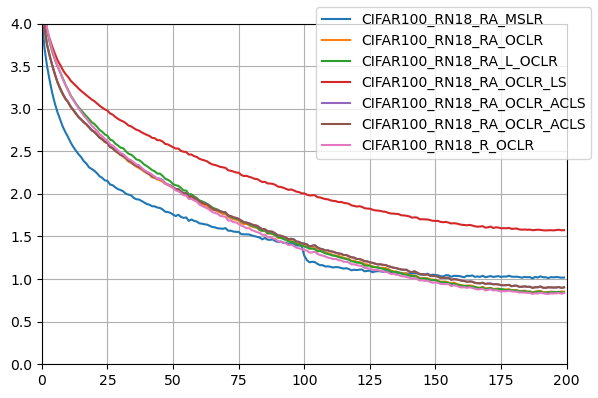

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
for name in names:
    ax.plot(results[name]['loss'], label=name)
ax.grid()
ax.set_ylim((0.0, 4.0))
ax.set_xlim((0, 200))
fig.tight_layout()
fig.legend()
plt.show()

In [76]:
for name in names:
    if not ('acc' in results[name]):
        results[name]['acc'] = evaluate_phase(name + '.pth', device=device)
    print(f'Acc: {name}, {results[name]['acc']:.5f}')

Acc: CIFAR100_RN18_RA_MSLR, 0.57660
Acc: CIFAR100_RN18_RA_OCLR, 0.58010
Acc: CIFAR100_RN18_RA_L_OCLR, 0.58190
Acc: CIFAR100_RN18_RA_OCLR_LS, 0.58840
Acc: CIFAR100_RN18_RA_OCLR_ACLS, 0.58310
Acc: CIFAR100_RN18_RA_OCLR_ACLS, 0.58310
Acc: CIFAR100_RN18_R_OCLR, 0.57980


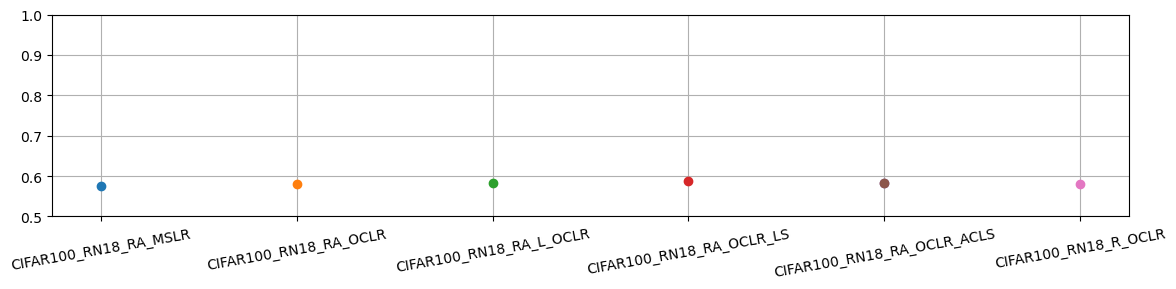

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
for name in names:
    ax.plot(name, results[name]['acc'], marker='o')
ax.grid()
ax.set_ylim((0.5, 1.0))
plt.xticks(rotation=10)
fig.tight_layout()
plt.show()